In [64]:
#Import libraries
import torch
import torchvision
from torchvision.datasets import VOCDetection
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2

## Automated Data Collection in Image Classification with CLIP

### Overview

This Jupyter Notebook is designed to showcase the automation of data collection processes for image classification tasks. We will be utilizing a variety of libraries, including `torch`, `torchvision`, `numpy`, `cv2`, `PIL`, `matplotlib`, `CLIP`, and `sklearn`, to facilitate various tasks throughout the notebook.

### Performance Evaluation of CLIP on VOC Dataset

We begin with a quantitative evaluation of the CLIP model's performance on the VOC dataset. This step is critical for assessing the model's classification accuracy and efficiency.

### Annotation and Refinement using Faster-RCNN and CLIP

Following the performance analysis, we proceed with a technical demonstration focused on using false positives from Faster-RCNN. Our aim is to accurately annotate and refine 2D detection regions, targeting our desired class of interest. This will be achieved by leveraging the text embedding capabilities of CLIP, which will assist in the precise categorization and refinement of the detection areas.


<h1>Evaluation of CLIP on the the PASCAL Visual Object Classes (VOC)</h1>

To start the project we will first evaluate CLIP's capabilities on the PASCAL Visual Object Classes (VOC) dataset. To limit the amount of data downloaded we will use its validation set along with its annotations.

<h2> Data Exploration

Let us first start expolring the data. The VOC dataset is already available in torchvision. 

In [65]:
# Uncoment to Download the PASCAL VOC dataset 
# dataset = VOCDetection(root="./data", year="2012", image_set="val", download=True)
# If already downloaded specify location to the data set download to false
dataset = VOCDetection(root='./data', year="2012", image_set="val", download=False)

In [66]:
#Lets check total data size
print(len(dataset))
# This should also give us some insight
print(dataset)

5823
Dataset VOCDetection
    Number of datapoints: 5823
    Root location: ./data


It looks like we have a total of 5823 images. We will now print out some information on them. 

------------{'annotation': {'folder': 'VOC2012', 'filename': '2008_000002.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '375', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'tvmonitor', 'pose': 'Frontal', 'truncated': '0', 'occluded': '0', 'bndbox': {'xmin': '34', 'ymin': '11', 'xmax': '448', 'ymax': '293'}, 'difficult': '0'}]}}------------------


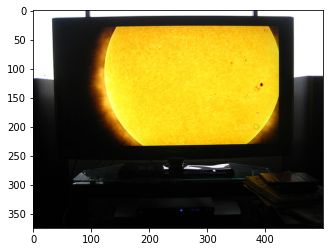

------------{'annotation': {'folder': 'VOC2012', 'filename': '2008_000003.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '333', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'train', 'pose': 'Unspecified', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '46', 'ymin': '11', 'xmax': '500', 'ymax': '333'}, 'difficult': '0'}, {'name': 'person', 'pose': 'Right', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '62', 'ymin': '190', 'xmax': '83', 'ymax': '243'}, 'difficult': '0'}]}}------------------


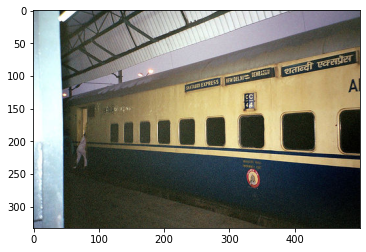

------------{'annotation': {'folder': 'VOC2012', 'filename': '2008_000007.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '375', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'boat', 'pose': 'Right', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '1', 'ymin': '230', 'xmax': '428', 'ymax': '293'}, 'difficult': '0'}]}}------------------


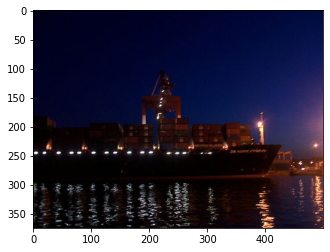

------------{'annotation': {'folder': 'VOC2012', 'filename': '2008_000009.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '375', 'depth': '3'}, 'segmented': '1', 'object': [{'name': 'cow', 'pose': 'Left', 'truncated': '0', 'occluded': '0', 'bndbox': {'xmin': '217', 'ymin': '161', 'xmax': '294', 'ymax': '221'}, 'difficult': '0'}, {'name': 'cow', 'pose': 'Rear', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '465', 'ymin': '167', 'xmax': '500', 'ymax': '218'}, 'difficult': '0'}]}}------------------


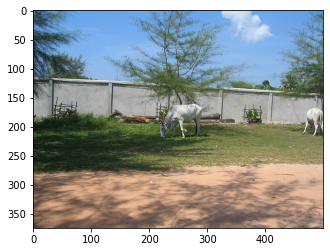

------------{'annotation': {'folder': 'VOC2012', 'filename': '2008_000016.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '375', 'depth': '3'}, 'segmented': '1', 'object': [{'name': 'tvmonitor', 'pose': 'Unspecified', 'truncated': '0', 'occluded': '0', 'bndbox': {'xmin': '91', 'ymin': '15', 'xmax': '392', 'ymax': '353'}, 'difficult': '0'}]}}------------------


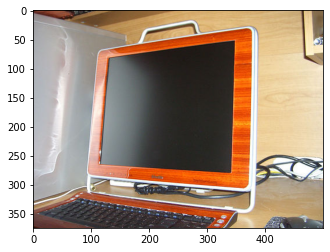

In [68]:
#Lets print out 5 images along with some information on the second tuple in dataset 

for i, (image, annotations) in enumerate(dataset):
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    print(f"------------{annotations}------------------")
    plt.imshow(image)
    plt.show()
    if i == 4:
        break
    

We will now look at one individual image within the datset. 

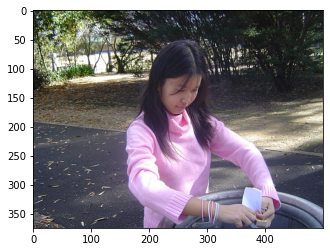

Annotation Datatype:<class 'dict'>


In [69]:
#Let us furhter explore the labeling of this dataset, let use image 100
img, annotation = dataset[100]
plt.imshow(img)
plt.show()

#Lets print some other information on the annotations
print(f"Annotation Datatype:{type(annotation)}")

In [70]:
#Lets explore each element in the annotation dictionary
for key, value in annotation['annotation'].items():
    print(f"{key}: {value}\n")

folder: VOC2012

filename: 2008_000406.jpg

source: {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}

size: {'width': '500', 'height': '375', 'depth': '3'}

segmented: 0

object: [{'name': 'person', 'pose': 'Frontal', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '159', 'ymin': '50', 'xmax': '430', 'ymax': '375'}, 'difficult': '0'}]



In [71]:
#Here we are interested only in the label as name and bounding box corresponding to that label
#In this case only one object was detected
print(len(annotation['annotation']['object']))

1


We will now draw a 2D bounding box using the ground labels from this dataset

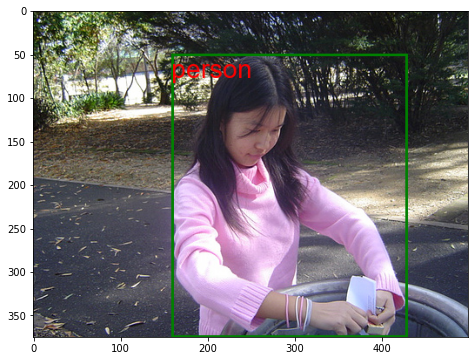

In [73]:
img_copy = img.copy()
draw = ImageDraw.Draw(img_copy)
# font = ImageFont.load_default()
#Add text
font = ImageFont.truetype("arial.ttf", 30)

#Use global valuees to be used later 
xmin = None
ymin = None 
xmax = None
ymax = None
label = None

for obj in annotation['annotation']['object']:
    #Get informaiton needed
    bbox = obj['bndbox']
    #Ensure box are int values
    xmin = int(bbox['xmin'])
    ymin = int(bbox['ymin'])
    xmax = int(bbox['xmax'])
    ymax = int(bbox['ymax'])
    label = obj['name']

    #Draw the 2D bounding box
    draw.rectangle(((xmin, ymin), (xmax, ymax)), outline="green", width=3)
    #Add label 
    draw.text((xmin, ymin), label, fill="red", font=font)

#Display the image with bounding boxes
plt.figure(figsize=(10, 6))
plt.imshow(img_copy)



The next steps is to cropp the image only in the region of interest

159 50 430 375 person


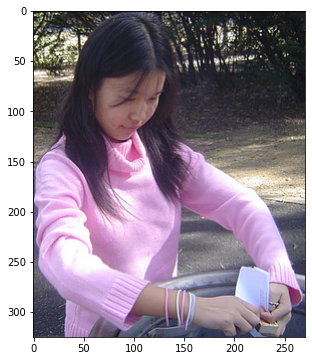

In [78]:
#We will now crop the image
print(xmin, ymin, xmax, ymax, label)
cropped_image = img.crop((xmin, ymin, xmax, ymax))

#Display cropped image
plt.figure(figsize=(10, 6))
plt.imshow(cropped_image)


## Data Processing and Storage

Having completed our exploration of the dataset, we now move to the next critical phase: data extraction and storage. This process involves meticulously cropping out the regions of interest as defined by the labeled bounding boxes in the VOC dataset. 

Each cropped image array will be systematically saved into a list, designated as `X_image_data`. Concurrently, the corresponding string labels for these images will be stored in a separate list, named `y_image_label`. This structured approach ensures organized and efficient handling of both the image data and their respective labls.
 `y


In [84]:
#We will now save each image into a list of arrays and each label in a list we will use tqdm as our progress bar
from tqdm import tqdm

#Declare empty lists
X_image_data = []
y_image_label = []
for image, annotations in tqdm(dataset):
    #Iterate over annotation data as previously done
    for obj in annotations['annotation']['object']:
        #Get informaiton needed
        bbox = obj['bndbox']
        #Ensure box are int values
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])
        label = obj['name']
        # print(label)
        #Use bndbox information to get cropped out desired image
        cropped_image = image.crop((xmin, ymin, xmax, ymax))
        X_image_data.append(cropped_image)
        y_image_label.append(label)
    
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5823/5823 [00:28<00:00, 204.78it/s]


Let us plot 25 random images from as a sanity check. 

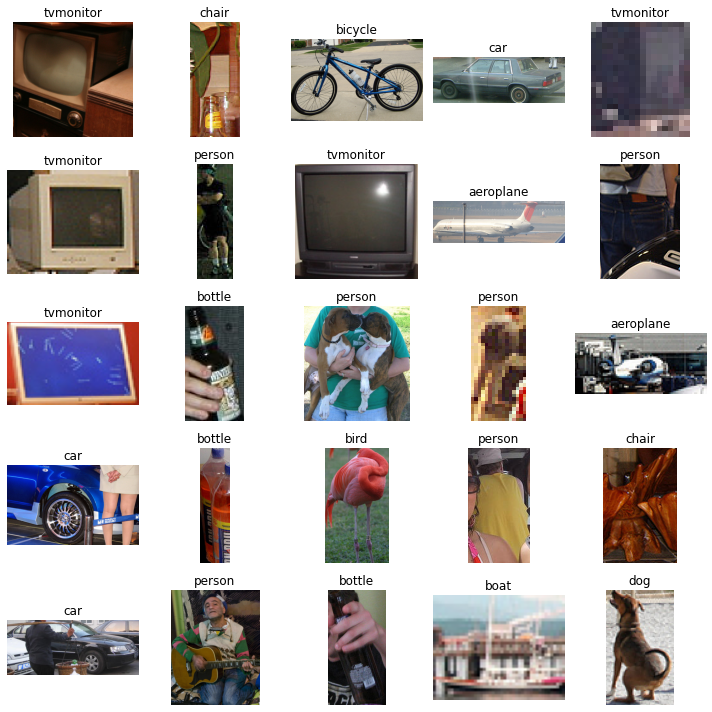

In [85]:
import random
#We will now see the results by randomly plotting 25 images
indices = random.sample(range(len(X_image_data)), 25)
sampled_images = [X_image_data[i] for i in indices]
sampled_labels = [y_image_label[i] for i in indices]

#Plotting the images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i in range(25):
    axes[i].imshow(sampled_images[i]) 
    axes[i].set_title(sampled_labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The images look good. Let us create a data frame using `pandas` to see the distribution of classes. 

In [142]:
import pandas as pd

#Let us further explore the labels we have in the created dataset
y_image_label_df = pd.DataFrame(y_image_label, columns=['image_label'])

In [143]:
print(y_image_label_df['image_label'].value_counts())

image_label
person         5110
chair          1449
car            1173
dog             773
bottle          733
bird            629
cat             618
pottedplant     542
boat            491
sheep           485
aeroplane       484
tvmonitor       414
sofa            387
bicycle         380
motorbike       376
diningtable     374
horse           373
cow             347
train           329
bus             320
Name: count, dtype: int64


The distribution is quite imbalanced with with the `person` class having more samples than the others. Below we can see we have a total of 20 unique labels, i.e classes in total. 

In [144]:
unique_labels = y_image_label_df['image_label'].unique().tolist()
print(unique_labels, len(unique_labels))

['tvmonitor', 'train', 'person', 'boat', 'cow', 'aeroplane', 'dog', 'car', 'bus', 'bottle', 'diningtable', 'chair', 'pottedplant', 'bird', 'cat', 'horse', 'motorbike', 'sheep', 'bicycle', 'sofa'] 20


### Sampling Strategy

In this assessment, our focus is not on any specific class, but rather on the overall accuracy performance of the model. To ensure a comprehensive evaluation, we aim to test the model with a substantial dataset. We have ensured that each class has a sufficient number of samples, allowing us to gather 100 samples from each class, culminating in a total of 2000 samples for the model testing.

To achieve this, we have employed stratified sampling. This method enables us to randomly select 100 images from each class, along with their corresponding labels, ensuring that the dataset is representative of the overall population.

### Data Reproducibility and File Loading

It's important to note that during the sampling process, I did not seed the random sampler for reproducibility. However, to facilitate consistent results and ease of use, the generated lists containing the stratified image data and labels have been saved into `.pkl` files: `X_stratified_images.pkl` and `y_stratified_labe

ls.pkl`.

To load these files and access the data, you can use the following Python code snippet:

```python
import pickle

# Load the image data
with open('X_stratified_images.pkl', 'rb') as file:
    X_stratified_images = pickle.load(file)

# Load the labels
with open('y_stratified_labels.pkl', 'rb') as file:
    y_stratified_labels = pickle.load(file)

The `X_stratified_images.pkl` is large you can acess all .pkl files files from the google drive link. The repo only has access to `y_pred` and `y_stratified_labels.pkl`


[Download Dataset](https://drive.google.com/file/d/1tTqoqjt22dpr6C3LBAlGKmXPLcm9ZVaO/view?usp=drive_link)


In [145]:
#In this case we will take 100 images for each class, hence we will do a stratified sampling of some sort
X_startified_images = []
y_startified_labels = []
for label in tqdm(unique_labels):
    #Get th indices for the current class
    class_indices = y_image_label_df.index[y_image_label_df['image_label'] == label]
    #Randomly selected 100 indexes
    selected_indices = random.sample(sorted(class_indices), 100)
    
    X_startified_images.extend([X_image_data[index] for index in selected_indices])
    y_startified_labels.extend([y_image_label[index] for index in selected_indices])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 407.94it/s]


Lets verify no issues occurred during the sampling process. 

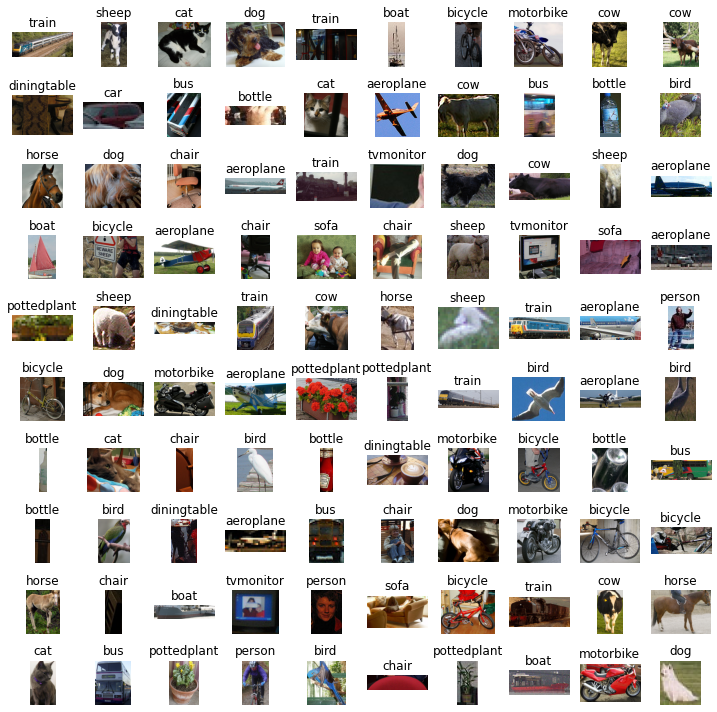

In [146]:
#We will now see the results again by randomly plotting 100 images
indices = random.sample(range(len(X_startified_images)), 100)
sampled_images = [X_startified_images[i] for i in indices]
sampled_labels = [y_startified_labels[i] for i in indices]

#Plotting the images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
axes = axes.ravel()

for i in range(100):
    axes[i].imshow(sampled_images[i]) 
    axes[i].set_title(sampled_labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [147]:
y_image_label_df = pd.DataFrame(y_startified_labels, columns=['image_label'])
print(y_image_label_df['image_label'].value_counts())
unique_labels = y_image_label_df['image_label'].unique().tolist()
print(unique_labels, len(unique_labels))

image_label
tvmonitor      100
train          100
bicycle        100
sheep          100
motorbike      100
horse          100
cat            100
bird           100
pottedplant    100
chair          100
diningtable    100
bottle         100
bus            100
car            100
dog            100
aeroplane      100
cow            100
boat           100
person         100
sofa           100
Name: count, dtype: int64
['tvmonitor', 'train', 'person', 'boat', 'cow', 'aeroplane', 'dog', 'car', 'bus', 'bottle', 'diningtable', 'chair', 'pottedplant', 'bird', 'cat', 'horse', 'motorbike', 'sheep', 'bicycle', 'sofa'] 20


Everything is looking good we are now ready to pass these over to CLIP to evluate its accuracy

# Annotating Sampled Images with CLIP

## Objective

We are now set to utilize the capabilities of CLIP for annotating each image in our sampled dataset. The process involves generating text prompts for every image, which CLIP will use for annotation. Our goal is to compare these annotations against the ground truth labels to evaluate the overall accuracy of the model.

## Installation of CLIP

Before proceeding, ensure that the CLIP library is installed in your environment. If you haven't already installed CLIP, you can do so directly from the GitHub repository. Run the following command in your notebook or terminal to install:

```bash
pip install git+https://github.com/openai/CLIP.git


In [148]:
#Installing CLIP uncomment to install
# !pip install git+https://github.com/openai/CLIP.git

#Import CLIP model
import clip

In [149]:
#Get device if you have gpu you should be able to use it, in my case I will use the cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#We will now get the model and its preprocessor
model, preprocess = clip.load("ViT-B/32", device=device)

cpu


In [150]:
#Pre-process text and add prompt
pre_text = [f"a photo of a {unique_label}." for unique_label in unique_labels]
print(pre_text, len(text))

['a photo of a tvmonitor.', 'a photo of a train.', 'a photo of a person.', 'a photo of a boat.', 'a photo of a cow.', 'a photo of a aeroplane.', 'a photo of a dog.', 'a photo of a car.', 'a photo of a bus.', 'a photo of a bottle.', 'a photo of a diningtable.', 'a photo of a chair.', 'a photo of a pottedplant.', 'a photo of a bird.', 'a photo of a cat.', 'a photo of a horse.', 'a photo of a motorbike.', 'a photo of a sheep.', 'a photo of a bicycle.', 'a photo of a sofa.'] 20


In [151]:
#Here we wil tokenize the text list using clip's tokenizer
text =  clip.tokenize(pre_text).to(device)
print(text)

tensor([[49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        ...,
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0]], dtype=torch.int32)


In [153]:
#We will now iterate over the image data, image should already be in PIL format
y_pred = []
for image in tqdm(X_startified_images):
    #unsqueeze is to add an extra dimension for batch and any pre-processing on the image needed
    image = preprocess(image).unsqueeze(0).to(device)
    #Pass through the CLIP network
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        #Get probabilities
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        #Get class label using argmax
        y_pred.append(unique_labels[np.argmax(probs)])
        # print(pre_text[y_pred])
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:49:48<00:00,  3.29s/it]


In [159]:
len(y_startified_labels) == len(y_pred)

True

In [3]:
#Saving in case work is lost
import pickle
import seaborn as sns

In [161]:
# # Saving lists as a file for images and labels
# with open('X_startified_images.pkl', 'wb') as file:
#     pickle.dump(X_startified_images, file)

In [162]:
# # Saving lists as a file for images and labels
# with open('y_startified_labels.pkl', 'wb') as file:
#     pickle.dump(y_startified_labels, file)

In [163]:
# # Saving lists as a file for images and labels
# with open('y_pred.pkl', 'wb') as file:
#     pickle.dump(y_pred, file)

In [6]:
# #To Load pickle files example 
# # # Loading my_list from a file
# with open('y_pred.pkl', 'rb') as file:
#     y_pred = pickle.load(file)
# with open('y_startified_labels.pkl', 'rb') as file:
#     y_startified_labels = pickle.load(file)
# # print(y_pred)
# # print(y_startified_labels)


In [15]:
#Let us get an accuracy score, precssisino and recall score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
a_score = accuracy_score(y_startified_labels, y_pred)
print(f"Accuracy score: {score*100}%")

Accuracy score: 79.3%


## Evaluation of CLIP's Performance on Raw Data

### Accuracy Metrics

Upon assessing the raw data, the accuracy achieved by our automated labeling process stands at 79.3%. This level of accuracy is quite satisfactory for an automatic data labeler. 

### Contextualizing the Accuracy

The primary objective of this pipeline is to significantly accelerate the labeling process through automation. While this efficiency is paramount, it's important to acknowledge that some degree of post-processing may still be necessary. This involves a careful review and potential removal of any images that might not be suitable for inclusion in our training set. 

### Advantages Over Manual Labeling

Despite the need for some manual oversight, this automated approach is substantially more efficient than the traditional method of manually identifying object regions, extracting these regions, and assigning labels individually. By reducing the labor-intensive aspects of data preparation, our system facilitates a quicker and more streamlined path towards preparing datasets for training machine learning models.


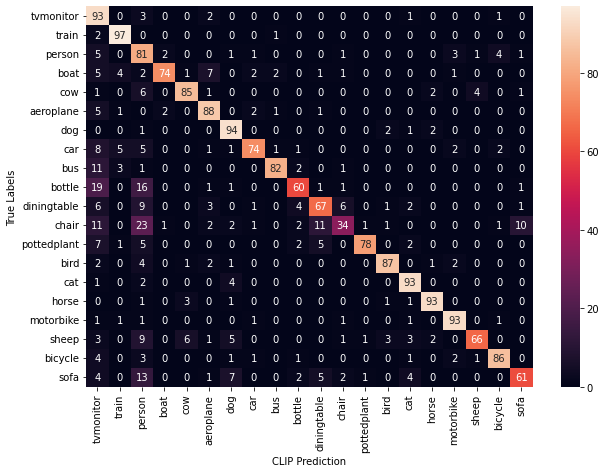

In [181]:
#We will now print out the confusion matrix 
cm = confusion_matrix(y_startified_labels, y_pred, labels=unique_labels)

#Let us now plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('CLIP Prediction')
plt.ylabel('True Labels')
plt.show()

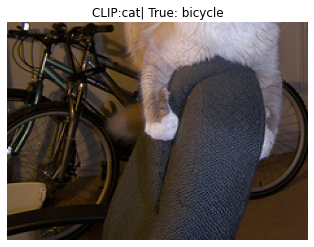

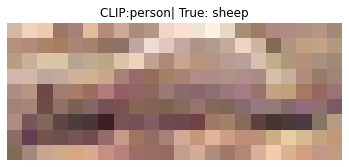

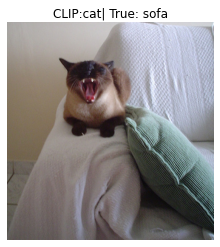

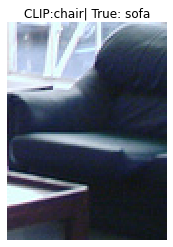

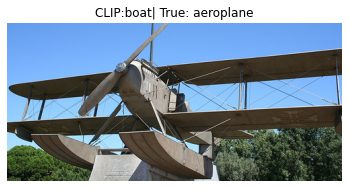

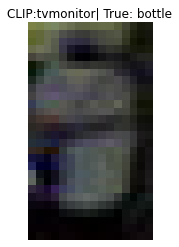

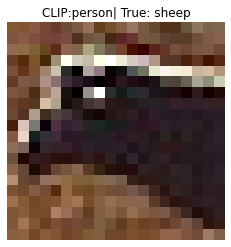

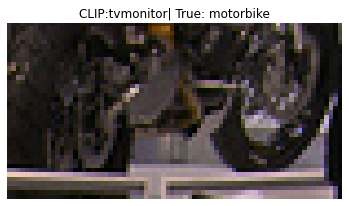

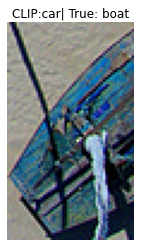

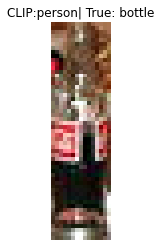

In [191]:
#Let us print out 50 of these wrongly labeled
#Let us get the indices of the ones that CLIP got wrong
incorrect_indices = [i for i, (clip_label, true_label) in enumerate(zip(y_pred, y_startified_labels)) if clip_label != true_label]
random.seed(20)
indices = random.sample(sorted(incorrect_indices), 10)
sampled_images = [X_startified_images[i] for i in indices]
sampled_labels = [y_startified_labels[i] for i in indices]
sampled_clip_labels = [y_pred[i] for i in indices]

# #Plotting the images in a 10x10 grid
# fig, axes = plt.subplots(2, 5, figsize=(10, 10))
# axes = axes.ravel()

for i in range(10):
    plt.imshow(sampled_images[i]) 
    plt.title(f"CLIP:{sampled_clip_labels[i]}| True: {sampled_labels[i]}")
    plt.axis('off')
    plt.show()

We can see here that for some mislabeled instances CLIP got a better classication than the manually labeled VOC data

<h1>Utilizing the Pipeline for Auto Data Labeling</h1>

In this section, we will demonstrate a practical example of employing the CLIP model to annotate images, particularly focusing on scenarios where data availability is limited. Let's consider a case where you need to develop a classifier to identify bees in flight, but you face a scarcity of relevant data.

### Leveraging Faster-RCNN for Region Detection

Our approach begins with the use of Faster-RCNN for detecting potential regions of interest within images. Although Faster-RCNN is trained on the COCO dataset, which may not perfectly recognize bees, it is adept at extracting semantically important features from objects to propose regions. We anticipate these region proposals might not be accurately labeled initially. However, these false postives will give us region proposals of objects. Faster-RCNN is an excellent candidate since it can take in any input image size. 

### Integrating CLIP for Accurate Annotation

To refine our approach, we will crop these proposed regions and use CLIP to re-annotate them. We employ text prompt embeddings like ["a photo of a bee in flight.", "mostly background"] to guide CLIP in accurately classifying these cropped images. Our goal is to filter and retain only those images that are correctly labeled as bees.

### Case Study: Bee Data

For this case study, we will work with a small dataset located in the `bee_data` folder, which contains 4 images of bees. From these, we successfully generate 18 accurately labeled images depicting bees in flight. This example showcases the pipeline's efficacy in augmenting limited datasets with precise, CLIP-annotated data.


In [315]:
import glob

In [316]:
#Let us first load the images
img_path = 'bee_data/*.jpg'
img_names = sorted(glob.glob(img_path))
print(img_names)

['bee_data\\bee_img_1.jpg', 'bee_data\\bee_img_2.jpg', 'bee_data\\bee_img_3.jpg', 'bee_data\\bee_img_4.jpg']


In [317]:
img = Image.open(img_names[0])

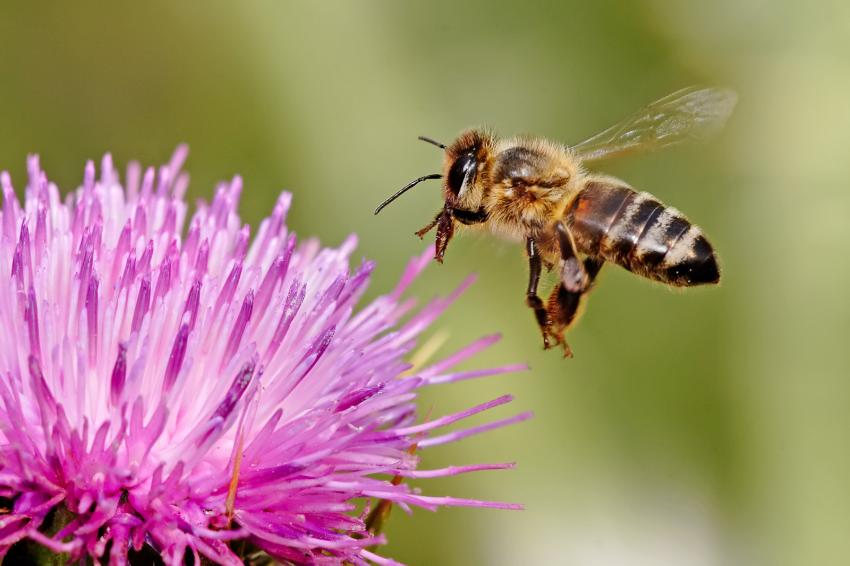

In [318]:
img

In [319]:
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn


# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

In [320]:
#Set model in evaluation mode
model.eval()
#Moving model to device
print(f"Moving Model to Device: {device}")
model.to(device)


# Define the transform including normalization
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


bboxes = []
pred_labels = []
conf_scores = []

#Keep only bboxes with specified confidence scores, we can increase to get less region proposals
CONFIDENCE_THRESHOLD = 0.7

#Lets convert the categorical names to actual names, the pre-trained fast RCNN uses the coco dataset 
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


for img_name in tqdm(img_names):
    image = Image.open(img_name)
    #add transform an norm along with batch dim
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    #Perform inference
    with torch.no_grad():
        prediction = model(image)
        #Extract boxes, labels, and scores
        boxes = prediction[0]['boxes']
        labels = prediction[0]['labels']
        scores = prediction[0]['scores']
    
        #Remove low confidence boxes
        keep = scores >= CONFIDENCE_THRESHOLD
        boxes = boxes[keep].cpu().numpy()
        labels = labels[keep].cpu().numpy()
        scores = scores[keep].cpu().numpy()
    
        bboxes.append(boxes)
        pred_labels.append([COCO_INSTANCE_CATEGORY_NAMES[label] for label in labels])
        conf_scores.append(scores)
    
    

Moving Model to Device: cpu


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.62s/it]


In [321]:
bboxes

[array([[396.76074, 114.62085, 728.3622 , 369.7367 ]], dtype=float32),
 array([[ 607.568  ,  135.03029,  894.2121 ,  387.45892],
        [ 588.82056,  465.65997, 1288.1969 ,  895.7574 ],
        [ 215.88226,  138.83888,  449.864  ,  321.90036],
        [ 831.21716,  491.47363, 1158.051  ,  911.05756]], dtype=float32),
 array([[3.3222303e-01, 1.8721292e+02, 1.6906612e+01, 2.2471333e+02],
        [4.0973169e+02, 1.7932378e+02, 4.3495740e+02, 2.0902980e+02],
        [2.9423300e+01, 1.7845731e+02, 4.7688148e+01, 2.0823616e+02],
        [3.4344092e+02, 1.2511976e+02, 3.6834232e+02, 1.5107410e+02],
        [6.7328789e+01, 8.8624680e+01, 9.5719406e+01, 1.1425766e+02],
        [8.0754753e+01, 1.3715338e+02, 1.0629644e+02, 1.5749213e+02],
        [3.7055347e+02, 1.5773709e+02, 4.0586359e+02, 1.8764879e+02]],
       dtype=float32),
 array([[  8.704706,  27.185734,  28.550104,  42.98527 ],
        [123.78537 ,  50.610146, 136.41739 ,  69.97869 ],
        [ 61.31001 ,  48.857037,  81.99857 ,  63.8

In [322]:
print(pred_labels)

[['cat'], ['cat', 'cat', 'cat', 'cat'], ['backpack', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat'], ['cat', 'horse', 'fork', 'cat']]


Let us now print all region proposals

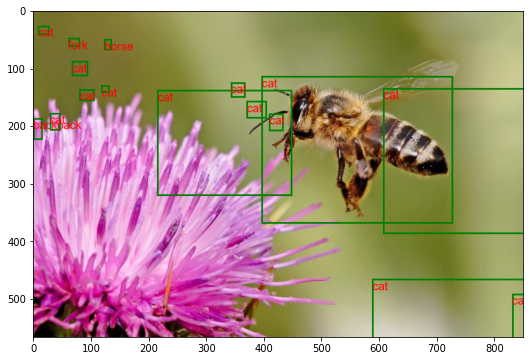

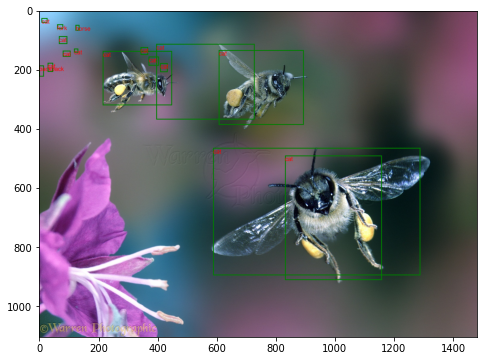

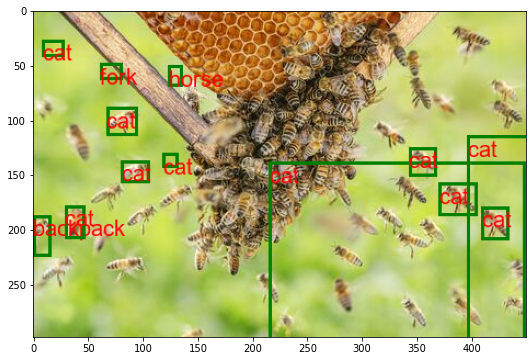

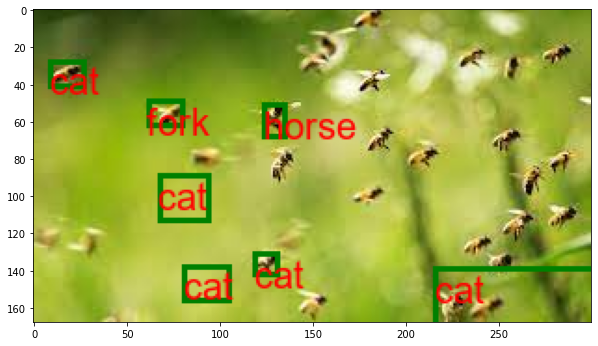

In [323]:
for img_name in img_names:
    img = Image.open(img_name)

    #Let us print out the detections
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    # font = ImageFont.load_default()
    #Add text
    font = ImageFont.truetype("arial.ttf", 20)
    
    #Iterate over each box and add label to it
    for boxes,labels in zip(bboxes, pred_labels):
        for box, label in zip(boxes, labels):
            #Get box dimensions
            xmin, ymin, xmax, ymax = box
        
            #Draw the 2D bounding box
            draw.rectangle(((xmin, ymin), (xmax, ymax)), outline="green", width=3)
            #Add label 
            draw.text((xmin, ymin), label, fill="red", font=font)
    
    #Display the image with bounding boxes
    plt.figure(figsize=(10, 6))
    plt.imshow(img_copy)
    plt.show()

In [324]:
#Let us now do the same pipline where we crop the image

#Declare empty lists
X_image_data = []
y_image_label = []


for img_name in tqdm(img_names):
    img = Image.open(img_name)

    #Let us print out the detections
    img_copy = img.copy()

    draw = ImageDraw.Draw(img_copy)
    
    #Iterate over each box and add label to it
    for boxes,labels in zip(bboxes, pred_labels):
        for box, label in zip(boxes, labels):
            try:
                #Get box dimensions
                xmin, ymin, xmax, ymax = box
                #Clip box dims to ensure no black boxes are extracted
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(img_copy.width, xmax)
                ymax = min(img_copy.height, ymax)
                #Use bndbox information to get cropped out desired image
                cropped_image = img_copy.crop((xmin, ymin, xmax, ymax))
                X_image_data.append(cropped_image)
                y_image_label.append(label)
            #Just ignore those it sturggles to cropped as specified
            except:
                pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 140.63it/s]


In [325]:
len(X_image_data)

52

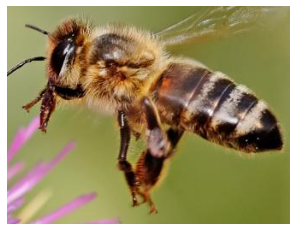

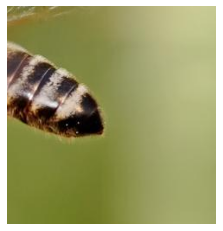

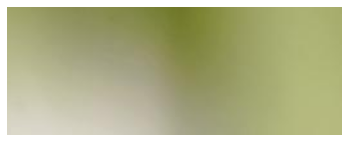

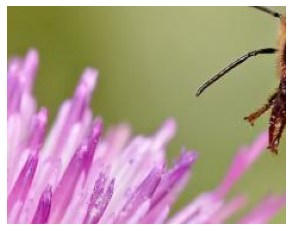

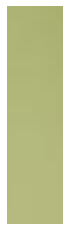

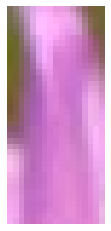

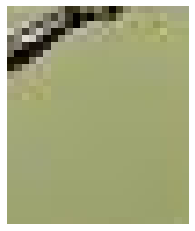

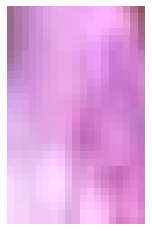

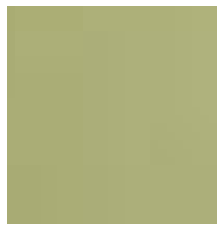

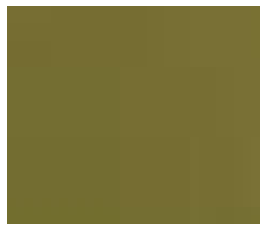

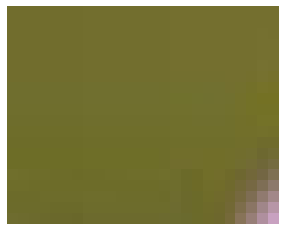

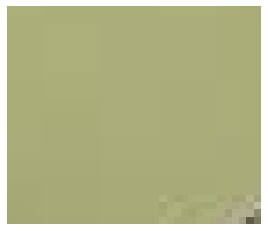

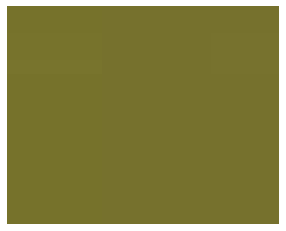

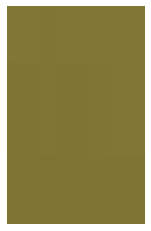

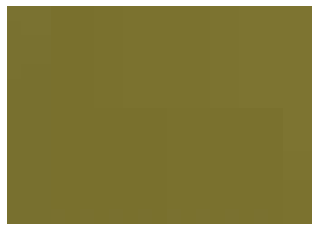

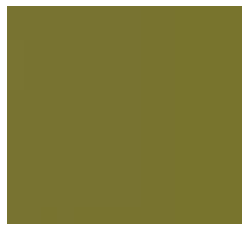

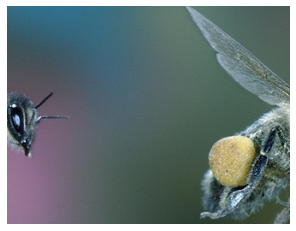

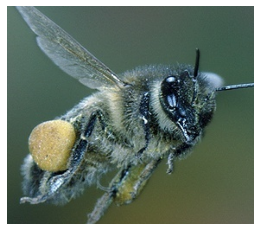

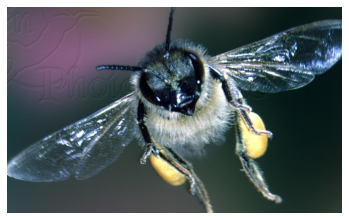

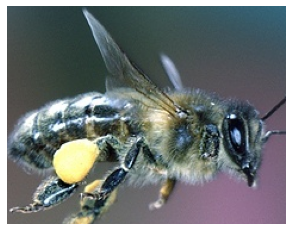

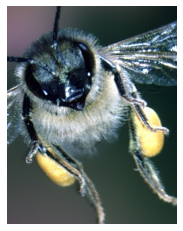

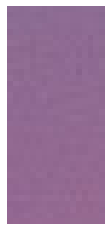

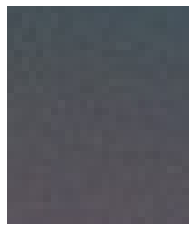

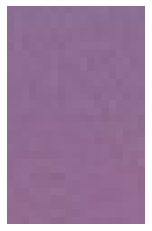

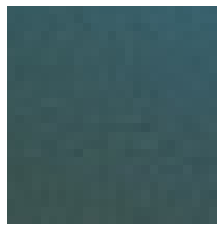

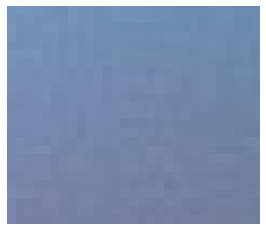

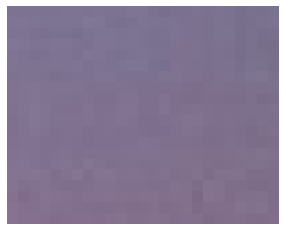

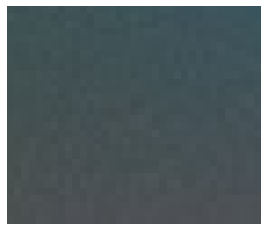

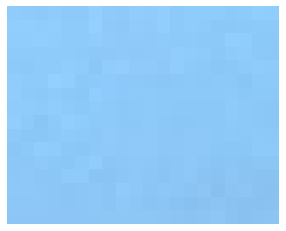

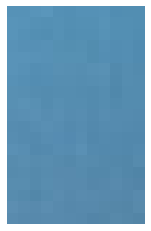

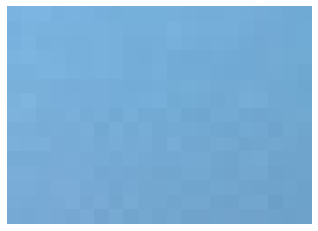

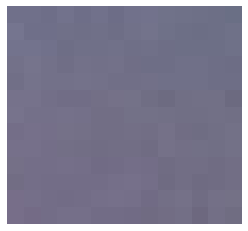

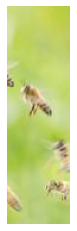

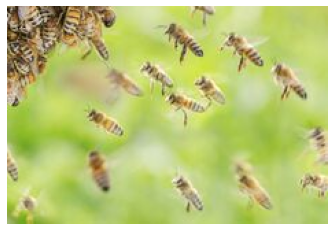

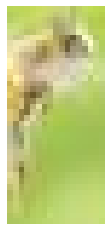

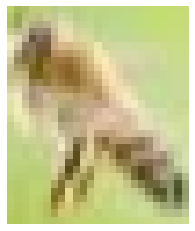

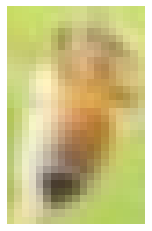

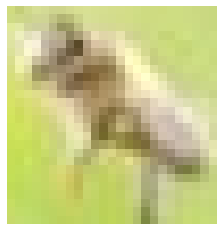

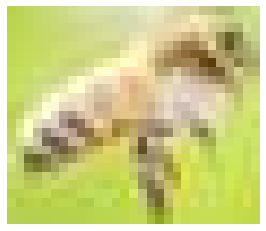

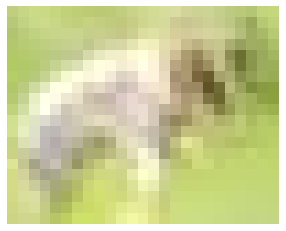

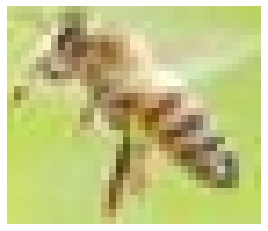

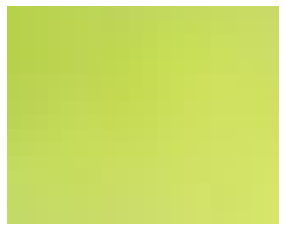

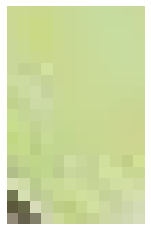

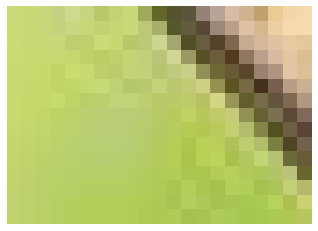

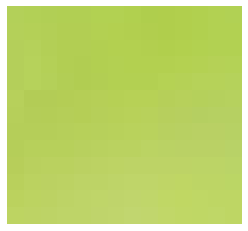

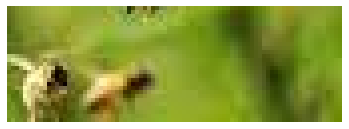

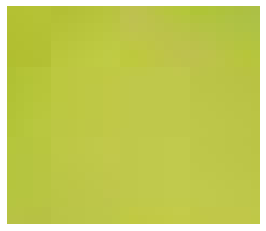

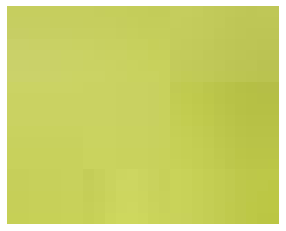

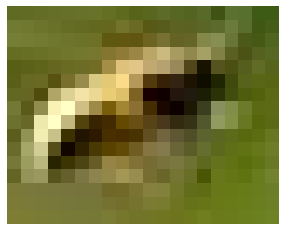

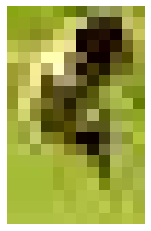

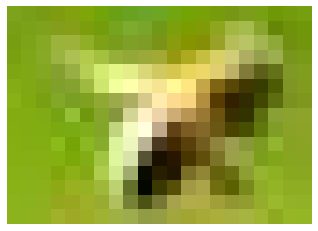

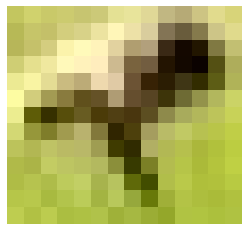

In [326]:
#Plot all cropped images
for img in X_image_data:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [327]:
#At this point the labels are not even close and we wont even need them here
len(y_image_label)

52

In [328]:
#We will now do the same thing and pass this over to the CLIP model who will clean up and label this data for us
model, preprocess = clip.load("ViT-B/32", device=device)
#Here we wil tokenize the text list using clip's tokenizer
text =  clip.tokenize(["a photo of a bee in flight.", "mostly background"]).to(device)


#We will now iterate over the image data, image should already be in PIL format
y_pred = []
for image in tqdm(X_image_data):
    #unsqueeze is to add an extra dimension for batch and any pre-processing on the image needed
    image = preprocess(image).unsqueeze(0).to(device)
    #Pass through the CLIP network
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        #Get probabilities
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        #Get class label
        y_pred.append(np.argmax(probs))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:38<00:00,  1.34it/s]


In [329]:
#So we at least have some bee predictions lets check it out remember bee is 0 class
indices = np.where(np.array(y_pred) == 0)[0]
print(indices)

[ 0  1  3 16 17 18 19 20 32 33 35 37 38 40 45 48 50 51]


In [330]:
new_labeled_data = [X_image_data[i] for i in indices]

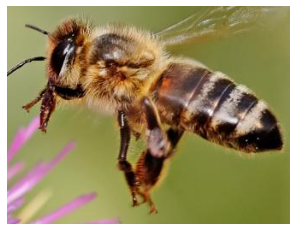

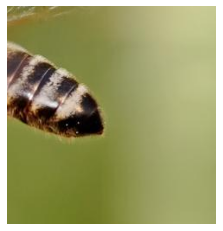

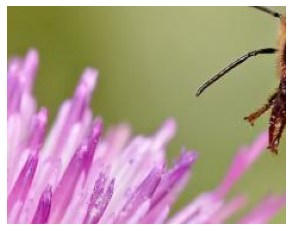

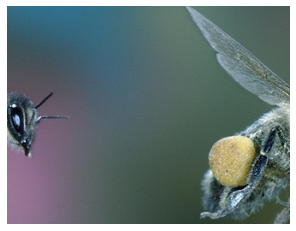

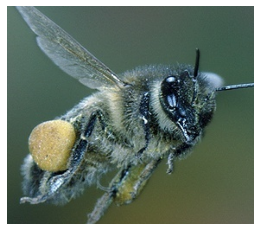

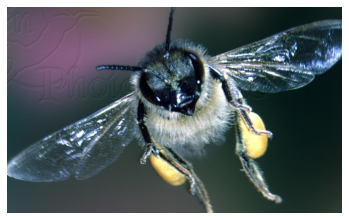

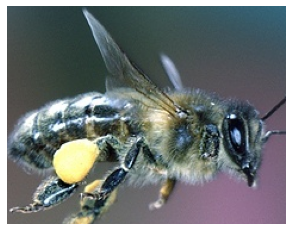

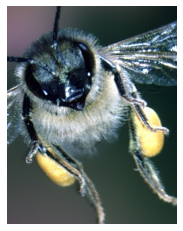

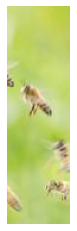

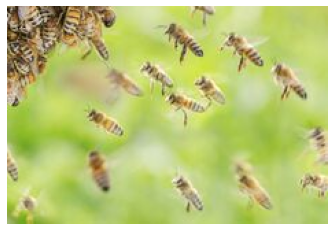

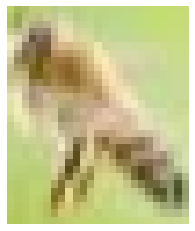

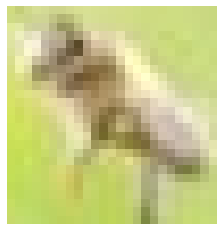

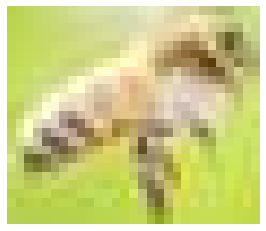

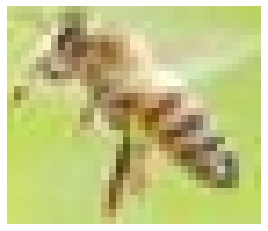

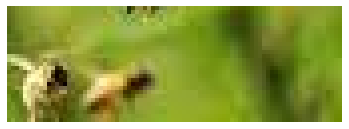

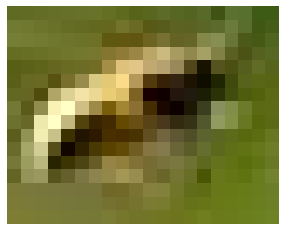

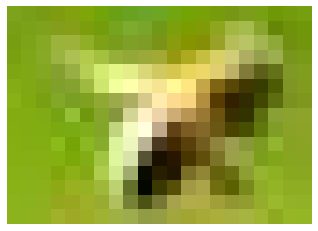

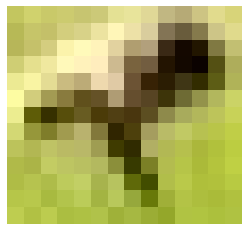

In [331]:
#Plot all images of bees or those clasfified as bees
for img in new_labeled_data:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [334]:
#Let us save the images
for i, bee_image in enumerate(new_labeled_data):
    bee_image.save(f"automated_bee_labled_data/auto_bee_labeled_data_{i}.png")

In [337]:
print(f"from 4 bee images {len(new_labeled_data)} of automatic data was created and labeled")

from 4 bee images 18 of automatic data was created and labeled


# Conclusion

## Insights from the Faster-RCNN and CLIP Integration

In our experiment, Faster-RCNN, set with a confidence threshold of 0.7, generated 52 region proposals. However, these initial proposals were not accurately classified and included regions with irrelevant content or mere backgrounds, alongside those potentially containing bees.

### Refinement Using CLIP

When these region proposals were processed through CLIP, equipped with targeted text embeddings, a remarkable outcome was observed. CLIP successfully identified and classified 18 out of these 52 regions as containing bees. Upon reviewing the output, it is evident that all 18 selected images indeed contain bees, validating the efficacy of our approach.

### Notable Observations and Considerations

An intriguing aspect of our results was the ability of the system to accurately identify bees even in images with very low pixel resolution. This highlights the robustness of CLIP in handling varied image qualities. However, it's worth noting a potential limitation: the presence of other insects in the images could pose a challenge to the specificity of the classification. This is an area that warrants further exploration to enhance the model's accuracy in more complex scenarios.
